In [127]:
import numpy as np
import torch

In [128]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# https://plotly.com/python/creating-and-updating-figures/
import plotly.graph_objects as go

In [129]:
import sys
sys.path.append('../') # now can access entire repository, (important when running locally)

from orbit_datasets import neworbits, versatileorbits, staticorbits

# Data Generation

In [130]:
orbits_dataset = neworbits.OrbitsDataset()
orbits_loader = torch.utils.data.DataLoader(
    dataset = orbits_dataset,
    shuffle = True,
    batch_size = 1,
)

Current dE:  [1.50990331e-14]
eccentricity:  [0.94157012]
Current dE:  [1.22393075e-07]
eccentricity:  [0.9999569]
Current dE:  [1.0658141e-14]
eccentricity:  [0.94013688]
It took 1.896561861038208 time to finish the job.


In [131]:
def getRepresentations(encoder_location, num_shown = 6000):
    branch_encoder = torch.load(encoder_location, map_location=torch.device('cpu'))
    branch_encoder.eval()
    
    encoder_outputs_list = []
    target_values = []

    for it, (input1, input2, y) in enumerate(orbits_loader):
        predicted_representation = branch_encoder(input1.float()).detach().numpy()[0]
        encoder_outputs_list.append(predicted_representation)

        #append conserved quantities to the end of the representation for plotting, y = (1, )
        #[2=phi0,3=energy,4=angular_momentum] discard [0=eccentricity, 1=semimajor_axis]
        target_values.append(np.array([y[0][2],y[0][3],y[0][4]]))
        
    encoder_outputs = np.vstack(encoder_outputs_list)
    target_values = np.vstack(target_values)


    dims = [encoder_outputs[:num_shown,i] for i in range(encoder_outputs.shape[1])]
    phi0_c_values = target_values[:num_shown,0]
    energy_c_values = target_values[:num_shown,1]
    angular_momentum_c_values = target_values[:num_shown,2]
    
    return dims, [phi0_c_values, energy_c_values, angular_momentum_c_values]

# Visualizing Models

In [152]:
ENCODER_PATH = "saved_models/3Dorbits_mseNCE_new/final_encoder.pt"
# ENCODER_PATH = "saved_models/3Dorbits_mseNCE_new/40_encoder.pt"
# ENCODER_PATH = "saved_models/3Dorbits_mseNCE_new/80_encoder.pt"

# ENCODER_PATH = "saved_models/4Dorbits_mseNCE/final_encoder.pt"
# ENCODER_PATH = "saved_models/4Dorbits_mseNCE/40_encoder.pt"

In [153]:
dims, conserved_quantities = getRepresentations(ENCODER_PATH)
phi0_c_values, energy_c_values, angular_momentum_c_values = conserved_quantities

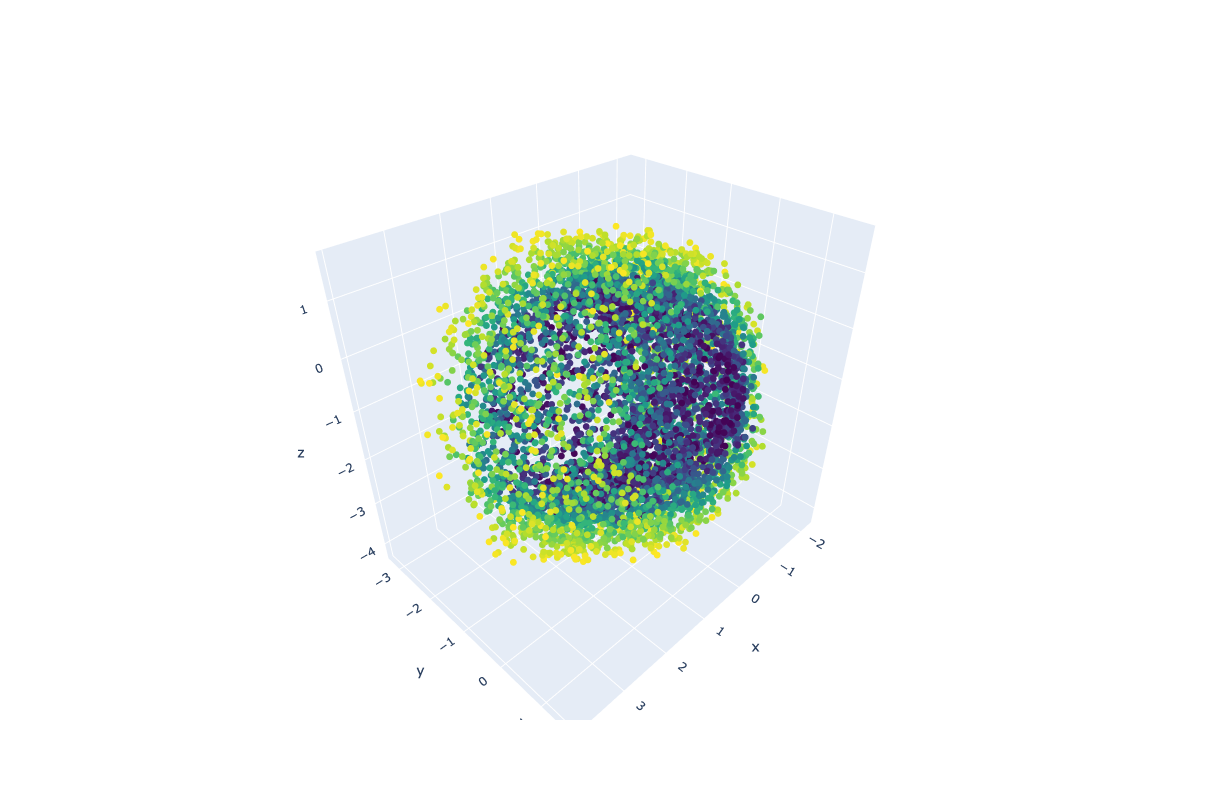

In [154]:
conserved_quantities = [phi0_c_values, energy_c_values, angular_momentum_c_values]
color = conserved_quantities[1]

fig = go.Figure(
        data=[go.Scatter3d(
        x=dims[0],
        y=dims[1],
        z=dims[2],
        mode='markers',
        marker=dict(
            size=4,
            color=color, # set color to an array/list of desired values
            colorscale='viridis',
            opacity=1
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()